##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Hand Landmarks Detection with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to detect hand landmarks from images.

## Preparation

Let's start with installing MediaPipe.

In [1]:
!pip install -q mediapipe

Then download an off-the-shelf model bundle. Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/hand_landmarker#models) for more information about this model bundle.

In [5]:
!curl -L -o hand_landmarker.task https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 21 7635k   21 1629k    0     0  1518k      0  0:00:05  0:00:01  0:00:04 1521k
 53 7635k   53 4061k    0     0  1958k      0  0:00:03  0:00:02  0:00:01 1959k
100 7635k  100 7635k    0     0  2581k      0  0:00:02  0:00:02 --:--:-- 2582k


## Visualization utilities

In [6]:
#@markdown We implemented some functions to visualize the hand landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

## Download test image

Let's grab a test image that we'll use later. The image is from [Unsplash](https://unsplash.com/photos/mt2fyrdXxzk).

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 67719  100 67719    0     0   113k      0 --:--:-- --:--:-- --:--:--  114k


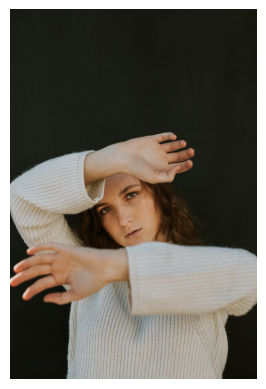

In [7]:
!curl -L -o image.jpg https://storage.googleapis.com/mediapipe-tasks/hand_landmarker/woman_hands.jpg

import cv2
import matplotlib.pyplot as plt

def cv2_imshow(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

img = cv2.imread("image.jpg")
cv2_imshow(img)

Optionally, you can upload your own image. If you want to do so, uncomment and run the cell below.

In [ ]:
# from google.colab import files
# uploaded = files.upload()

# for filename in uploaded:
#   content = uploaded[filename]
#   with open(filename, 'wb') as f:
#     f.write(content)

# if len(uploaded.keys()):
#   IMAGE_FILE = next(iter(uploaded))
#   print('Uploaded file:', IMAGE_FILE)

## Running inference and visualizing the results

Here are the steps to run hand landmark detection using MediaPipe.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/hand_landmarker/python) to learn more about configuration options that this solution supports.


In [1]:
import cv2
import numpy as np
import mediapipe as mp

# Helper function to draw landmarks
def draw_landmarks_on_image(rgb_image, detection_result):
    hand_landmarks_list = detection_result.hand_landmarks
    annotated_image = np.copy(rgb_image)

    for hand_landmarks in hand_landmarks_list:
        # Draw each landmark point
        for landmark in hand_landmarks:
            x = int(landmark.x * annotated_image.shape[1])
            y = int(landmark.y * annotated_image.shape[0])
            cv2.circle(annotated_image, (x, y), 5, (0, 255, 0), -1)

    return annotated_image


In [2]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=2)
detector = vision.HandLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file("image.jpg")

# STEP 4: Detect hand landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the classification result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))




NameError: name 'cv2_imshow' is not defined

In [1]:
import cv2
import numpy as np
import mediapipe as mp
import os
from mediapipe.tasks import python
from mediapipe.tasks.python import vision


In [2]:
# Load hand landmark model
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=1)
detector = vision.HandLandmarker.create_from_options(options)

In [3]:
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

def classify_gesture(hand_landmarks, image_width, image_height):
    coords = [(int(lm.x * image_width), int(lm.y * image_height)) for lm in hand_landmarks]

    # Finger tips
    tips = [4, 8, 12, 16, 20]

    # Check finger states (1 = open, 0 = closed)
    fingers = []
    for tip_id in tips[1:]:
        if coords[tip_id][1] < coords[tip_id - 2][1]:
            fingers.append(1)
        else:
            fingers.append(0)

    # Thumb check
    thumb = 1 if coords[4][0] > coords[3][0] else 0
    finger_state = [thumb] + fingers

    if finger_state == [0,0,0,0,0]:
        return "Fist"
    elif finger_state == [1,1,1,1,1]:
        return "Open Palm"
    elif finger_state == [1,0,0,0,0]:
        return "Thumbs Up"
    elif finger_state == [0,1,0,0,0]:
        return "Pointing"
    else:
        return "Unknown"

# Fungsi gesture recognition
def recognize_gesture(coords):
    tips = [4, 8, 12, 16, 20]  # thumb, index, middle, ring, pinky
    
    # Cek finger state (1 = open, 0 = closed)
    fingers = []
    for tip_id in tips[1:]:
        if coords[tip_id][1] < coords[tip_id - 2][1]:  # bandingkan tip sama pip
            fingers.append(1)
        else:
            fingers.append(0)

    # Cek jempol (agak tricky, pake orientasi wrist id 0)
    if coords[4][0] < coords[3][0] and coords[4][0] < coords[0][0]:
        thumb = 1
    else:
        thumb = 0

    finger_state = [thumb] + fingers

    # Rule-based recognition
    if finger_state == [0,0,0,0,0]:
        return "Fist"
    elif finger_state == [1,1,1,1,1]:
        return "Open Palm"
    elif finger_state == [1,0,0,0,0]:
        return "Thumbs Up"
    elif finger_state == [0,1,0,0,0]:
        return "Pointing"
    elif finger_state == [0,1,1,0,0]:
        return "Peace"
    elif finger_state == [0,0,0,0,1]:
        return "Promise"
    elif finger_state == [0,1,0,0,1]:
        return "Rock 🤘"
    elif finger_state == [1,0,0,0,1]:
        return "Call Me 🤙"
    elif finger_state == [1,1,1,0,0]:
        return "Three"
    elif finger_state == [0,1,1,1,1]:
        return "Four"
    else:
        return "Unknown"

In [4]:
import subprocess

def control_usb(enable=True):
    DEVCON_PATH = r"C:\Program Files (x86)\Windows Kits\10\Tools\10.0.26100.0\x64\devcon.exe"   # ganti sesuai lokasi devcon kamu
    DEVICE_ID = "HID\VID_248A&PID_FA02&MI_00&Col01"  # ganti sesuai device id kamu
    try:
        if enable:
            result = subprocess.run(
                [DEVCON_PATH, "enable", DEVICE_ID],
                capture_output=True, text=True
            )
            print(result.stdout, result.stderr)
            print("✅ USB ENABLED")
        else:
            result = subprocess.run(
                [DEVCON_PATH, "disable", DEVICE_ID],
                capture_output=True, text=True
            )
            print(result.stdout, result.stderr)
            print("❌ USB DISABLED")
    except Exception as e:
        print("⚠️ Error:", e)


In [5]:
HAND_CONNECTIONS = mp.solutions.hands.HAND_CONNECTIONS
last_gesture = None

def draw_landmarks_on_image(rgb_image, detection_result):
    global last_gesture
    hand_landmarks_list = detection_result.hand_landmarks
    annotated_image = np.copy(rgb_image)

    for hand_landmarks in hand_landmarks_list:
        image_h, image_w, _ = annotated_image.shape

        # Draw landmarks
        landmark_points = []
        for landmark in hand_landmarks:
            x = int(landmark.x * image_w)
            y = int(landmark.y * image_h)
            landmark_points.append((x, y))
            cv2.circle(annotated_image, (x, y), 5, (0, 255, 0), -1)

        # Draw skeleton
        for connection in HAND_CONNECTIONS:
            start = landmark_points[connection[0]]
            end = landmark_points[connection[1]]
            cv2.line(annotated_image, start, end, (0, 0, 255), 2)

        # Gesture classification
        gesture = classify_gesture(hand_landmarks, image_w, image_h)

        # Debounce
        if gesture != last_gesture:
            last_gesture = gesture
            if gesture == "Fist":
                control_usb(enable=False)
            elif gesture == "Thumbs Up":
                control_usb(enable=True)

        # Display label
        cv2.putText(annotated_image, gesture, (10, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    return annotated_image


In [6]:
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)

    detection_result = detector.detect(mp_image)
    annotated_frame = draw_landmarks_on_image(rgb_frame, detection_result)

    cv2.imshow("Hand Gesture USB Control", cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR))

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
#!/usr/bin/env python3

HID\VID_248A&PID_FA02&MI_00&COL01\7&1F829BFD&0&0000         : Disabled
1 device(s) disabled.
 
❌ USB DISABLED
HID\VID_248A&PID_FA02&MI_00&COL01\7&1F829BFD&0&0000         : Disabled
1 device(s) disabled.
 
❌ USB DISABLED
HID\VID_248A&PID_FA02&MI_00&COL01\7&1F829BFD&0&0000         : Enabled
1 device(s) are enabled.
 
✅ USB ENABLED
HID\VID_248A&PID_FA02&MI_00&COL01\7&1F829BFD&0&0000         : Enabled
1 device(s) are enabled.
 
✅ USB ENABLED
HID\VID_248A&PID_FA02&MI_00&COL01\7&1F829BFD&0&0000         : Enabled
1 device(s) are enabled.
 
✅ USB ENABLED
HID\VID_248A&PID_FA02&MI_00&COL01\7&1F829BFD&0&0000         : Enabled
1 device(s) are enabled.
 
✅ USB ENABLED
HID\VID_248A&PID_FA02&MI_00&COL01\7&1F829BFD&0&0000         : Enabled
1 device(s) are enabled.
 
✅ USB ENABLED
HID\VID_248A&PID_FA02&MI_00&COL01\7&1F829BFD&0&0000         : Enabled
1 device(s) are enabled.
 
✅ USB ENABLED
HID\VID_248A&PID_FA02&MI_00&COL01\7&1F829BFD&0&0000         : Disabled
1 device(s) disabled.
 
❌ USB DISABLED
HID\